# Set Up and Load Model

In [1]:
!pip install timm==0.6.7
!pip install torch==2.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 79.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 110.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [2]:
!git clone https://github.com/isl-org/ZoeDepth.git

Cloning into 'ZoeDepth'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 111 (delta 26), reused 14 (delta 14), pack-reused 75
Receiving objects: 100% (111/111), 4.10 MiB | 14.58 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [3]:
cd ZoeDepth

/content/ZoeDepth


In [4]:
import torch
import numpy as np
import cv2
from torchvision import transforms
from zoedepth.utils.misc import colorize
import matplotlib.pyplot as plt

zoe = torch.hub.load(".", "ZoeD_NK", source="local", pretrained=True)
zoe = zoe.to('cuda')

transform = transforms.Compose([
    transforms.ToTensor()
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # typical mean and std
])

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


img_size [384, 512]


/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _V

Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_NK.pt


Downloading: "https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_NK.pt" to /root/.cache/torch/hub/checkpoints/ZoeD_M12_NK.pt
100%|██████████| 1.35G/1.35G [00:05<00:00, 262MB/s]


Loaded successfully


# Functions

In [5]:
def read_frame_from_video(video_path: str, frame_number: int):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame

def estimate(frame: np.ndarray):
    tensor = transform(frame).unsqueeze(0).to(zoe.device)
    depth = zoe.infer(tensor)
    return depth.squeeze().cpu().detach().numpy()

def visualize(frame: np.ndarray, depth: np.ndarray):
    colored_depth = colorize(depth)
    fig, axs = plt.subplots(1,2, figsize=(15,7))
    for ax, im, title in zip(axs, [frame, colored_depth], ['Input', 'Predicted Depth']):
      ax.imshow(im)
      ax.axis('off')
      ax.set_title(title)
    return

def get_z_value(depth: np.ndarray, x: int, y: int):
    if y < depth.shape[0] and x < depth.shape[1]:
        return depth[y, x]
    else:
        return "Coordinate out of bounds"

# Testing

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
video_path = "/content/drive/MyDrive/Project/Object_tracking/scan_video1.avi"
frame_number = 300

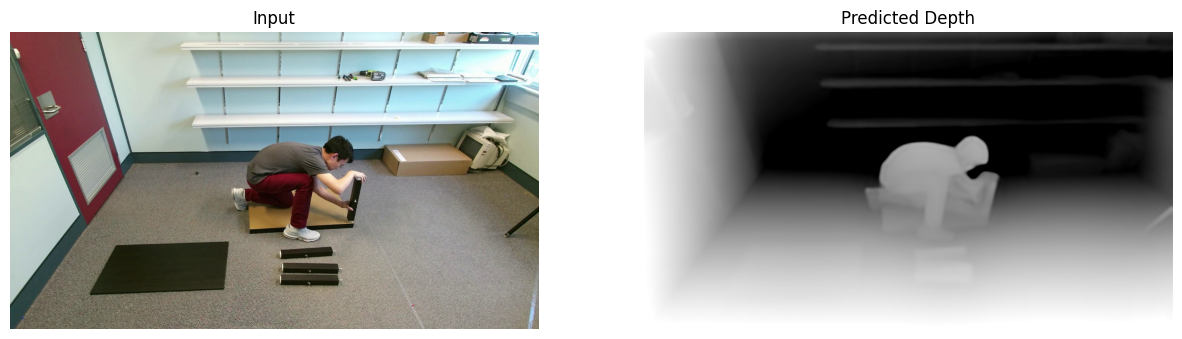

In [8]:
frame = read_frame_from_video(video_path, frame_number)
depth = estimate(frame)
visualize(frame, depth)

In [9]:
depth.shape

(1080, 1920)

In [10]:
x_test = 100
y_test = 100
z_test = get_z_value(depth, x_test, y_test)
z_test

2.0002818

In [11]:
np.save("/content/drive/MyDrive/Project/Object_tracking/depth_frame_300.npy", depth)

# Process CSV